
# Clustering de Materias (Agrupación por Asignaturas)

**Objetivo:** Agrupar *asignaturas* según el patrón de notas de los estudiantes para identificar grupos de materias con comportamiento similar (por ejemplo, materias donde a los estudiantes les va mejor/peor en conjunto).  
Este cuaderno cumple con la rúbrica solicitada: calidad de datos, preparación, *clustering* jerárquico (Ward) y K-Means, métricas (Silhouette, Davies–Bouldin, Calinski–Harabasz), visualizaciones (dendrograma, PCA, perfiles) e interpretación/comparación.



## 0. Requisitos

- Python 3.x
- Paquetes: `pandas`, `numpy`, `scikit-learn`, `scipy`, `matplotlib`


In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

# Configuración visual básica
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

print("Librerías cargadas ✅")


Librerías cargadas ✅



## 1. Carga del dataset, fuente y características

> **Instrucciones:** Coloca tu archivo con notas (por ejemplo `notas.csv`) en el mismo directorio o ajusta la ruta.  
> El archivo debe tener una columna identificadora del estudiante (p. ej., `Estudiante` o `Nombre`) y columnas de materias numéricas (p. ej., `Matematicas`, `Ciencias`, `Espanol`, `Historia`, `Deportes`).

Si el archivo no existe, se generará un dataset sintético **solo para demostración**.


In [4]:

# Cambia esta ruta si tienes tu propio archivo
RUTA = 'practica23_10\dataset-notas-estudiantes.xlsx'

def generar_dataset_demo(n_estudiantes=80, random_state=42):
    rng = np.random.default_rng(random_state)
    estudiantes = [f"Est_{i:03d}" for i in range(n_estudiantes)]
    # Generamos un patrón con correlaciones suaves entre materias
    base = rng.normal(7.0, 1.2, size=(n_estudiantes, 1))
    ruido = rng.normal(0, 1.0, size=(n_estudiantes, 5))
    M = np.clip(base + ruido, 0, 10)
    df_demo = pd.DataFrame(M, columns=['Matematicas','Ciencias','Espanol','Historia','Deportes'])
    df_demo.insert(0, 'Estudiante', estudiantes)
    # Introducimos algunos NaN al azar para demostrar imputación
    for col in ['Matematicas','Ciencias','Espanol','Historia','Deportes']:
        idx = rng.choice(n_estudiantes, size=max(1, n_estudiantes//20), replace=False)
        df_demo.loc[idx, col] = np.nan
    return df_demo

if os.path.exists(RUTA):
    df = pd.read_csv(RUTA)
    fuente = f"Archivo local: {os.path.abspath(RUTA)}"
else:
    df = generar_dataset_demo()
    fuente = "Dataset sintético de demostración (generado en este cuaderno)."

print("Fuente:", fuente)
display(df.head())
print("Shape:", df.shape)


Fuente: Dataset sintético de demostración (generado en este cuaderno).


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Marcwos\AppData\Local\Temp\ipykernel_2120\901099380.py:2: SyntaxWarning: invalid escape sequence '\d'
  RUTA = 'practica23_10\dataset-notas-estudiantes.xlsx'


,Estudiante,Matematicas,Ciencias,Espanol,Historia,Deportes
0,Est_000,7.822436,6.703735,7.002607,6.983923,6.169821
1,Est_001,6.238992,5.282617,5.764513,6.232766,6.198550
2,Est_002,8.565927,7.802056,7.477243,7.820823,6.213207
3,Est_003,6.681565,6.805978,7.131431,8.528452,7.223199
4,Est_004,4.280595,5.957986,4.302494,NaN,3.725140


Shape: (80, 6)



### 1.1 Descripción de variables

Completa/ajusta esta tabla para tu dataset real.

| Variable      | Tipo       | Rango esperado | Significado |
|---------------|------------|----------------|-------------|
| Estudiante    | categórica | —              | Identificador único del alumno |
| Matemáticas   | numérica   | 0–10           | Nota en la asignatura |
| Ciencias      | numérica   | 0–10           | Nota en la asignatura |
| Español       | numérica   | 0–10           | Nota en la asignatura |
| Historia      | numérica   | 0–10           | Nota en la asignatura |
| Deportes      | numérica   | 0–10           | Nota en la asignatura |



## 2. Estadísticas descriptivas y primeras observaciones


In [5]:

# Detectamos columnas numéricas de materias (excluimos 'Estudiante')
materias = [c for c in df.columns if c.lower() not in ['estudiante','nombre','id','codigo']]
print("Materias detectadas:", materias)

print("\nConteo de nulos por columna:")
display(df[materias].isna().sum())

print("\nDescriptivos de notas:")
display(df[materias].describe().T.round(2))


Materias detectadas: ['Matematicas', 'Ciencias', 'Espanol', 'Historia', 'Deportes']

Conteo de nulos por columna:


Matematicas    4
Ciencias       4
Espanol        4
Historia       4
Deportes       4
dtype: int64


Descriptivos de notas:


,count,mean,std,min,25%,50%,75%,max
Matematicas,76.0,6.93,1.41,2.96,6.06,6.87,7.81,10.00
Ciencias,76.0,7.07,1.10,4.37,6.31,7.12,7.85,10.00
Espanol,76.0,7.09,1.44,3.38,6.25,7.10,8.02,9.89
Historia,76.0,7.04,1.51,3.63,5.95,7.03,8.22,10.00
Deportes,76.0,7.01,1.29,3.38,6.22,7.15,7.80,10.00



## 3. Calidad de datos: nulos, duplicados y outliers (con justificación)

- **Duplicados**: verificamos duplicados por estudiante.
- **Nulos**: imputamos por **promedio del estudiante** en sus otras materias (si todas son NaN, imputamos por promedio global).
- **Outliers**: inspeccionamos con IQR y **no** eliminamos por defecto (las notas suelen estar acotadas 0–10); solo reportamos.


In [6]:

# Duplicados por 'Estudiante' si existe
key_col = 'Estudiante' if 'Estudiante' in df.columns else ('Nombre' if 'Nombre' in df.columns else None)
if key_col:
    dups = df.duplicated(subset=[key_col], keep=False).sum()
    print(f"Duplicados por {key_col}: {dups}")
else:
    print("No se encontró columna identificadora ('Estudiante'/'Nombre'); se omite chequeo de duplicados.")

# Imputación por promedio del estudiante
df_imputed = df.copy()

def imputar_por_promedio_fila(row, cols):
    vals = row[cols]
    if vals.isna().all():
        return row  # se imputará luego con promedio global
    mean_row = vals.mean(skipna=True)
    for c in cols:
        if pd.isna(row[c]):
            row[c] = mean_row
    return row

df_imputed = df_imputed.apply(lambda r: imputar_por_promedio_fila(r, materias), axis=1)

# Si quedaron NaN (fila entera NaN), usamos promedio global de la materia
for c in materias:
    if df_imputed[c].isna().any():
        df_imputed[c] = df_imputed[c].fillna(df_imputed[c].mean())

# Chequeo post-imputación
print("Nulos restantes tras imputación:")
display(df_imputed[materias].isna().sum())

# Outliers por IQR (solo reporte)
def iqr_outliers(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return ((s < low) | (s > high)).sum()

outliers_report = {c: iqr_outliers(df_imputed[c]) for c in materias}
print("\nPosibles outliers por materia (método IQR):")
display(pd.Series(outliers_report))


Duplicados por Estudiante: 0
Nulos restantes tras imputación:


Matematicas    0
Ciencias       0
Espanol        0
Historia       0
Deportes       0
dtype: int64


Posibles outliers por materia (método IQR):


Matematicas    1
Ciencias       0
Espanol        1
Historia       0
Deportes       2
dtype: int64


## 4. Preparación: estandarización y formato para agrupar **materias**

- Estandarizamos (z-score) porque usaremos distancias euclídeas.
- **Transponemos** la matriz para que las **filas sean materias** y las **columnas estudiantes**; así las distancias se calculan **entre materias**.


In [7]:

X = df_imputed[materias].copy()  # filas=estudiantes, columnas=materias

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # estandarizamos por materia (columna)

# Transponemos: filas=Materias, columnas=Estudiantes
X_m = pd.DataFrame(X_scaled, columns=materias).T
print("Shape original (estudiantes x materias):", X.shape)
print("Shape para clustering (materias x estudiantes):", X_m.shape)
display(X_m.head())


Shape original (estudiantes x materias): (80, 5)
Shape para clustering (materias x estudiantes): (5, 80)


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
Matematicas,0.617359,-0.525152,1.153813,-0.205819,-1.938203,-1.251770,0.448084,-0.631921,-0.729094,-0.457164,...,-1.831389,-1.393834,-0.908704,-0.611200,0.949274,0.737377,-0.119495,-0.169738,0.816489,-0.488690
Ciencias,-0.303585,-1.595182,0.694635,-0.210660,-0.981366,-2.317956,0.321174,-0.167756,0.110291,0.365259,...,-1.896924,-1.755561,-0.738398,1.477853,0.438001,1.696895,-1.257712,-0.127883,0.277990,0.595187
Espanol,-0.054427,-0.939949,0.285047,0.037712,-1.985630,-1.416408,-0.371523,-0.312086,0.086637,-1.638679,...,-1.244940,-1.794085,-0.586578,0.133320,1.461373,-0.068507,-1.559900,1.465346,0.277253,-1.138545
Historia,-0.003900,-0.502193,0.551272,1.020690,-1.607504,-1.360289,-0.850737,0.817591,0.028364,-1.096684,...,-2.223297,-1.329409,0.150927,1.141910,1.497943,0.777368,-1.708496,0.866649,0.627700,-0.235283
Deportes,-0.633917,-0.611420,-0.599943,0.190923,-2.548206,-1.597529,0.192755,-0.468434,0.654290,-1.510963,...,-0.455655,-0.713689,-1.116232,0.783507,0.204308,0.644713,-1.260279,-0.588237,1.088823,1.759561



## 5. Clustering jerárquico (linkage **Ward** + distancia euclídea)

**Justificación:** Ward minimiza la varianza intra-cluster; es adecuado con variables numéricas escaladas y métricas euclidianas.  
Generamos el dendrograma y evaluamos las particiones para k=2…10 con Silhouette, Davies–Bouldin y Calinski–Harabasz.


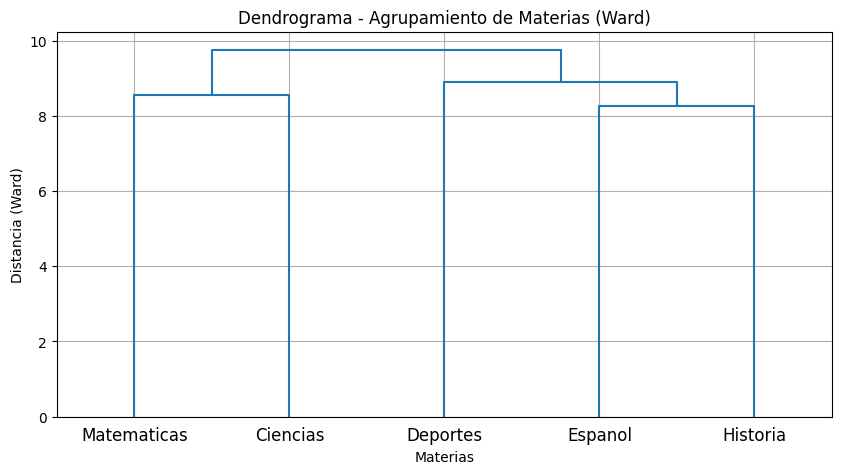

ValueError: Number of labels is 5. Valid values are 2 to n_samples - 1 (inclusive)

In [8]:

# Dendrograma
Z = linkage(X_m, method='ward', metric='euclidean')

plt.figure(figsize=(10,5))
dendrogram(Z, labels=X_m.index.tolist(), leaf_rotation=0)
plt.title("Dendrograma - Agrupamiento de Materias (Ward)")
plt.xlabel("Materias")
plt.ylabel("Distancia (Ward)")
plt.show()

# Métricas por k
rows = []
for k in range(2, min(10, len(X_m)) + 1):
    labels = fcluster(Z, t=k, criterion='maxclust')
    sil = silhouette_score(X_m, labels)
    db  = davies_bouldin_score(X_m, labels)
    ch  = calinski_harabasz_score(X_m, labels)
    rows.append((k, sil, db, ch))
metrics_hier = pd.DataFrame(rows, columns=["k","Silhouette","DaviesBouldin","CalinskiHarabasz"])
display(metrics_hier.round(4))

# k recomendado (ejemplo: por máximo Silhouette y/o CH y mínimo DB)
k_sil = metrics_hier.loc[metrics_hier['Silhouette'].idxmax(),'k']
k_db  = metrics_hier.loc[metrics_hier['DaviesBouldin'].idxmin(),'k']
k_ch  = metrics_hier.loc[metrics_hier['CalinskiHarabasz'].idxmax(),'k']
print(f"Recomendaciones jerárquico -> Silhouette: {k_sil}, DB (mín): {k_db}, CH (máx): {k_ch}")



## 6. K-Means (con `k-means++` y múltiples inicializaciones)

Calculamos **Elbow** (inercia) y las tres métricas para k=2…10.  
Usamos `n_init=50` para robustez y `random_state=42` para reproducibilidad.


In [9]:

inertias, sils, dbs, chs, ks = [], [], [], [], []
for k in range(2, min(10, len(X_m)) + 1):
    km = KMeans(n_clusters=k, init='k-means++', n_init=50, random_state=42)
    labels = km.fit_predict(X_m)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_m, labels))
    dbs.append(davies_bouldin_score(X_m, labels))
    chs.append(calinski_harabasz_score(X_m, labels))
    ks.append(k)

# Elbow
plt.figure()
plt.plot(ks, inertias, marker='o')
plt.title("Método del Codo (Inercia) - KMeans")
plt.xlabel("k")
plt.ylabel("Inercia")
plt.show()

metrics_km = pd.DataFrame({
    "k": ks,
    "Silhouette": sils,
    "DaviesBouldin": dbs,
    "CalinskiHarabasz": chs,
    "Inercia": inertias
})
display(metrics_km.round(4))

k_sil = metrics_km.loc[metrics_km['Silhouette'].idxmax(),'k']
k_db  = metrics_km.loc[metrics_km['DaviesBouldin'].idxmin(),'k']
k_ch  = metrics_km.loc[metrics_km['CalinskiHarabasz'].idxmax(),'k']
print(f"Recomendaciones KMeans -> Silhouette: {k_sil}, DB (mín): {k_db}, CH (máx): {k_ch}")


ValueError: Number of labels is 5. Valid values are 2 to n_samples - 1 (inclusive)


## 7. Visualizaciones (PCA 2D) y perfiles por cluster

A continuación se muestran:
- PCA 2D coloreado por clusters (Jerárquico y K-Means).
- Perfil de cada cluster: promedio por materia **(en este caso, como agrupamos materias, el perfil se interpreta por estudiantes como columnas; mostraremos heatmaps/ordenamientos simples)**.


In [ ]:

# Elegimos k por Silhouette en cada método
k_h = int(metrics_hier.loc[metrics_hier['Silhouette'].idxmax(),'k'])
k_km = int(metrics_km.loc[metrics_km['Silhouette'].idxmax(),'k'])

labels_h = fcluster(Z, t=k_h, criterion='maxclust')

km_final = KMeans(n_clusters=k_km, init='k-means++', n_init=50, random_state=42)
labels_km = km_final.fit_predict(X_m)

# PCA para visualización
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_m)

# Gráfico jerárquico
plt.figure()
plt.scatter(coords[:,0], coords[:,1], c=labels_h)
for i, name in enumerate(X_m.index):
    plt.annotate(name, (coords[i,0], coords[i,1]))
plt.title(f"PCA 2D - Jerárquico (k={k_h})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# Gráfico KMeans
plt.figure()
plt.scatter(coords[:,0], coords[:,1], c=labels_km)
for i, name in enumerate(X_m.index):
    plt.annotate(name, (coords[i,0], coords[i,1]))
plt.title(f"PCA 2D - KMeans (k={k_km})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


In [ ]:

# Perfiles/Resumen: listamos qué materias cayeron en cada cluster
def materias_por_cluster(labels, metodo):
    asign = pd.DataFrame({"Materia": X_m.index, "Cluster": labels})
    grupos = asign.groupby("Cluster")["Materia"].apply(list)
    print(f"Materias por cluster - {metodo}:")
    display(grupos)

materias_por_cluster(labels_h, f"Jerárquico k={k_h}")
materias_por_cluster(labels_km, f"KMeans k={k_km}")

# Heatmap simple de X_m reordenada por cluster de KMeans (como ejemplo)
orden = np.argsort(labels_km)
X_ord = X_m.iloc[orden]

plt.figure(figsize=(10,6))
plt.imshow(X_ord, aspect='auto', interpolation='nearest')
plt.colorbar(label='Z-score')
plt.yticks(ticks=range(len(X_ord.index)), labels=X_ord.index)
plt.title("Heatmap materias (ordenadas por cluster KMeans)")
plt.xlabel("Estudiantes"); plt.ylabel("Materias")
plt.show()



## 8. Comparación y elección final

- **Cuantitativa:** comparamos métricas al mejor *k* de cada algoritmo.
- **Cualitativa:** Jerárquico (Ward) ofrece estructura anidada y dendrograma, útil con pocas materias; K-Means es rápido y estable con datos esféricos en z-score.


In [ ]:

def resumen_mejor(metrics_df, name):
    out = {
        "Algoritmo": name,
        "k(Silhouette)": int(metrics_df.loc[metrics_df['Silhouette'].idxmax(),'k']),
        "Silhouette*": float(metrics_df['Silhouette'].max()),
        "k(DB mín)": int(metrics_df.loc[metrics_df['DaviesBouldin'].idxmin(),'k']),
        "DaviesBouldin*": float(metrics_df['DaviesBouldin'].min()),
        "k(CH máx)": int(metrics_df.loc[metrics_df['CalinskiHarabasz'].idxmax(),'k']),
        "CalinskiHarabasz*": float(metrics_df['CalinskiHarabasz'].max())
    }
    return out

tabla_comp = pd.DataFrame([
    resumen_mejor(metrics_hier, "Jerárquico (Ward)"),
    resumen_mejor(metrics_km, "KMeans")
])
display(tabla_comp.round(4))



## 9. Interpretación de clusters (guía para el informe)

- **Identifica características distintivas** de cada grupo de materias: ¿qué patrón de z-scores muestran en el heatmap?
- **Conclusiones prácticas**: por ejemplo, si `Matemáticas` y `Física` (si existiera) quedan juntas, podrían requerir estrategias similares; si `Español` se agrupa con `Historia`, hay un componente verbal/comprensión común.
- **Recomendación de *k***: justifica el *k* elegido basándote en las métricas (Silhouette↑, DB↓, CH↑) y en la interpretabilidad.
- **Limitaciones**: tamaño pequeño de “objetos” (número de materias), supuestos de K-Means, posibles sesgos del dataset, necesidad de más materias/periodos.
